# 1. Importing Libraries and loading the data

In [27]:
%matplotlib inline
! pip install seaborn --quiet

In [2]:
# Simple python imports
import math

# Importing data processing libraries
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

# Importing data visualization libraries
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('ggplot')
# %config InlineBackend.figure_format = 'retina' # Retina display

# Importing jupyter widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Importing file system libraries
import pickle

# Importing machine learning libraries
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor

pd.options.display.max_columns = None

In [3]:
raw_data = pd.read_csv('/content/car_prices_clean_v2.csv')

df = raw_data.copy()

df.head()

,full_name,selling_price,seller_type,km_driven,owner_type,fuel_type,transmission_type,mileage,engine,max_power,seats,age
0,Toyota Land Cruiser 200 V8 Petrol,92.0,Dealer,80000,First Owner,Petrol,Automatic,9.00,4461.0,285.40,8.0,6
1,Land Rover Range Rover Sport 3.0 D SE,92.0,Dealer,9500,First Owner,Diesel,Automatic,12.65,2993.0,296.00,5.0,5
2,Toyota Land Cruiser Prado VXL,87.5,Dealer,36000,First Owner,Diesel,Automatic,11.00,2982.0,170.63,7.0,3
3,BMW 7 Series 730Ld DPE Signature,85.0,Individual,50000,First Owner,Diesel,Automatic,16.77,2993.0,261.49,5.0,4
4,BMW 7 Series 730Ld DPE Signature,85.0,Dealer,19000,First Owner,Diesel,Automatic,17.66,2993.0,355.37,4.0,4


# 2. Exploratory Data Analysis
In this section, we would be exploring the dataset and try to find patterns, which would be helpful in *feature engineering* when we build a model to predict the price of a used car

### 2.0 Helper functions for EDA

In [4]:
# Function to get a genreal overview of the data with some basic statistics
def overview_data(data: pd.DataFrame, col: str) -> None:
	'''
	Input arguments:
	- data : pandas dataframe
	- col : column name

	Outputs:
	- None : Prints the overview of the column:
				- Distinct count
				- Distinct %
				- Missing count
				- Missing %
				- Mean
				- Minimum
				- Maximum
	'''
	t = PrettyTable(['Measure', 'Value'])
	t.add_row(['Distinct Count', data[col].nunique()])
	t.add_row(['Distinct %', data[col].nunique()/data.shape[0]*100])
	t.add_row(['Missing Count', data[col].isna().sum()])
	t.add_row(['Missing %', data[col].isna().sum()/data.shape[0]*100])
	t.add_row(['Mean', data[col].mean()])
	t.add_row(['Minimum', data[col].min()])
	t.add_row(['Maximum', data[col].max()])

	# Display the overview of the dataframe
	print(f'Overview of column "{col}"')
	print(t)
	
	print('\n')
	return

# Function to get the quantile statistics for a numeric column
def quantile_statistics_for_column(data: pd.DataFrame, col: str) -> dict:
	'''
	Input arguments:
	- data : pandas dataframe
	- col : column name

	Outputs:
	- quantile_stats: Returns a dictionary with quantile stats for the column which includes:
							- min : Minimum value
							- 5% : 5th percentile value
							- q1 : First quartile value
							- median : Median value
							- q3 : Third quartile value
							- 95% : 95th percentile value
							- max : Maximum value
							- range: Range of values
							- IQR : Interquartile range
	'''

	# Check if the column exists in the dataframe
	if col not in data.columns:
		print(f'Column {col} not found in the dataframe')
		return
	
	# Check if the column is numeric
	if data[col].dtype != 'float64' and data[col].dtype != 'int64':
		print(f'Column {col} is not numeric')
		return

	quantile_stats = {}
	quantile_stats['min'] = data[col].min()
	quantile_stats['5%'] = data[col].quantile(0.05)
	quantile_stats['Q1'] = data[col].quantile(0.25)
	quantile_stats['median'] = data[col].median()
	quantile_stats['Q3'] = data[col].quantile(0.75)
	quantile_stats['95%'] = data[col].quantile(0.95)
	quantile_stats['max'] = data[col].max()
	quantile_stats['range'] = quantile_stats['max'] - quantile_stats['min']
	quantile_stats['IQR'] = quantile_stats['Q3'] - quantile_stats['Q1']

	# Display the quantile stats
	print(f'Quantile stats for column "{col}"')
	t = PrettyTable(['Statistic', 'Value'])
	t.add_row(['Minimum', quantile_stats['min']])
	t.add_row(['5th Percentile', quantile_stats['5%']])
	t.add_row(['First Quartile, Q1', quantile_stats['Q1']])
	t.add_row(['Median', quantile_stats['median']])
	t.add_row(['Third Quartile, Q3', quantile_stats['Q3']])
	t.add_row(['95th Percentile', quantile_stats['95%']])
	t.add_row(['Maximum', quantile_stats['max']])
	t.add_row(['Range', quantile_stats['range']])
	t.add_row(['Interquartile Range', quantile_stats['IQR']])
	print(t)

	print('\n')
	return quantile_stats

# Function to get the descriptive statistics for a numeric column
def descriptive_statistics_for_column(data: pd.DataFrame, col: str) -> dict:
	'''
	Input arguments:
	- data : pandas dataframe
	- col : column name

	Outputs:
	- descriptive_stats : Return a dictionary with descriptive stats for the column which includes:
								- mean: Mean
								- sum: Sum
								- var: Variance
								- std : Standard deviation
								- CV : Coefficient of variation
								- kurtosis: Kurtosis
								- MAD: Mean Absolute Deviation
								- skewness: Skewness
								- mono: true if monotonous

	'''

	# Check if the column exists in the dataframe
	if col not in data.columns:
		print(f'Column {col} not found in the dataframe')
		return
	
	# Check if the column is numeric
	if data[col].dtype != 'float64' and data[col].dtype != 'int64':
		print(f'Column {col} is not numeric')
		return
	
	descriptive_stats = {}
	descriptive_stats['mean'] = data[col].mean()
	descriptive_stats['sum'] = data[col].sum()
	descriptive_stats['var'] = data[col].var()
	descriptive_stats['std'] = data[col].std()
	descriptive_stats['CV'] = descriptive_stats['std'] / descriptive_stats['mean']
	descriptive_stats['kurtosis'] = data[col].kurtosis()
	descriptive_stats['MAD'] = data[col].mad()
	descriptive_stats['skewness'] = data[col].skew()
	descriptive_stats['mono'] = data[col].is_monotonic_increasing or data[col].is_monotonic_decreasing

	# Display the descriptive stats
	print(f'Descriptive stats for column "{col}"')
	t = PrettyTable(['Statistic', 'Value'])
	t.add_row(['Mean', descriptive_stats['mean']])
	t.add_row(['Sum', descriptive_stats['sum']])
	t.add_row(['Variance', descriptive_stats['var']])
	t.add_row(['Standard deviation', descriptive_stats['std']])
	t.add_row(['Coefficient of variation', descriptive_stats['CV']])
	t.add_row(['Kurtosis', descriptive_stats['kurtosis']])
	t.add_row(['Mean absolute deviation', descriptive_stats['MAD']])
	t.add_row(['Skewness', descriptive_stats['skewness']])
	t.add_row(['Monotonous', descriptive_stats['mono']])
	print(t)

	print('\n')
	return descriptive_stats

# Function to get the max and min values for a numeric column
def extremums_for_column(data: pd.DataFrame, col: str, n: int = 5) -> pd.DataFrame:
	'''
	Input arguments:
	- data : pandas dataframe
	- col : column name

	Outputs:
	- extremums: Return a dataframe with extremums for the column which includes:
					- max_n: "n" largest values in the column
					- min_n: "n" smallest values in the column

	'''

	# Check if the column exists in the dataframe
	if col not in data.columns:
		print(f'Column "{col}" not found in the dataframe')
		return
	
	# Check if the column is numeric
	if data[col].dtype != 'float64' and data[col].dtype != 'int64':
		print(f'Column "{col}" is not numeric')
		return
	
	extremums = {}
	extremums['max_n'] = data[col].value_counts().sort_index(ascending=False).head(5)
	extremums['min_n'] = data[col].value_counts().sort_index(ascending=True).head(5)

	# Display the extremums
	print(f'Extremums for column "{col}"')

	print(f'Maximum {n} values')
	t = PrettyTable(['Value', 'Count', 'Freq'])
	for (index, value) in extremums['max_n'].iteritems():
		t.add_row([index, value, value / len(data[col]) * 100])
	print(t)

	print(f'Minimum {n} values')
	t = PrettyTable(['Value', 'Count', 'Freq'])
	for (index, value) in extremums['min_n'].iteritems():
		t.add_row([index, value, value / len(data[col]) * 100])
	print(t)

	print('\n')
	return extremums

# Function to check the most frquently occuring values (preferably for a categorical column)
def common_values(data: pd.DataFrame, col: str, n: int = 5) -> pd.DataFrame:
	'''
	Input arguments:
	- data : pandas dataframe
	- col : column name

	Outputs:
	- common_values: Return a dataframe with common values for the column which includes:
						- value: Common value in the column
						- count: Count of the value in the column
						- freq: Frequency of the value in the column
	'''

	n_values = data[col].value_counts().nlargest(n)
	common_values = pd.DataFrame()
	common_values['value'] = n_values.index
	common_values['count'] = n_values.values
	common_values['freq'] = 100 * common_values['count'] / data[col].count()

	# Display the common values
	print(f'Common values for column "{col}"')
	t = PrettyTable(['Value', 'Count', 'Frequency'])
	for (v, c, f) in zip(common_values['value'], common_values['count'], common_values['freq']):
		t.add_row([v, c, f])
	print(t)

	print('\n')
	return common_values

def categorical_overview(data: pd.DataFrame, col: str) -> pd.DataFrame:
	'''
	Input arguments:
	- data : pandas dataframe
	- col : column name

	Outputs:
	- None: Prints the overview of the categorical column:
			- Distinct: Number of distinct values in the column
			- Distinct (%) : Percentage of distinct values in the column
			- Missing: Number of missing values in the column
			- Missing (%) : Percentage of missing values in the column
	'''

	t = PrettyTable(['Measure', 'Value'])
	t.add_row(['Distinct Count', data[col].nunique()])
	t.add_row(['Distinct %', data[col].nunique()/data.shape[0]*100])
	t.add_row(['Missing Count', data[col].isna().sum()])
	t.add_row(['Missing %', data[col].isna().sum()/data.shape[0]*100])

	# Display the unique values
	print(f'Overview of column "{col}"')
	print(t)

	print('\n')

In [5]:
def analyze_data(df: pd.DataFrame, col: str, **kwargs) -> dict():
	n = kwargs.get('n', 5)
	
	# Check if column exists in the dataframe
	if col not in df.columns:
		print(f'Column "{col}" not found in the dataframe')
		return
		
	# Check if the column is numeric
	if df[col].dtype == 'float64' or df[col].dtype == 'int64':
		print(f'\tAnalyzing: Column "{col}" is numeric\n')		
		overview_data(df, col)
		quantile_stats = quantile_statistics_for_column(df, col)
		descriptive_stats = descriptive_statistics_for_column(df, col)
		extremums = extremums_for_column(df, col, n)
		common_val = common_values(df, col, n)
		return { 'quantile_stats': quantile_stats, 
					'descriptive_stats': descriptive_stats, 
					'extremums': extremums,
					'common_values': common_val
					}
	else:
		print(f'Column "{col}" is categorical')
		categorical_overview(df, col)
		common_val = common_values(df, col, n)
		return { 'common_values': common_val }

## 2.1 Variable Types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10321 entries, 0 to 10320
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   full_name          10321 non-null  object 
 1   selling_price      10321 non-null  float64
 2   seller_type        10321 non-null  object 
 3   km_driven          10321 non-null  int64  
 4   owner_type         10321 non-null  object 
 5   fuel_type          10321 non-null  object 
 6   transmission_type  10321 non-null  object 
 7   mileage            10321 non-null  float64
 8   engine             10321 non-null  float64
 9   max_power          10321 non-null  float64
 10  seats              10321 non-null  float64
 11  age                10321 non-null  int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 967.7+ KB


The categorical variables are:
- `full_name`
- `seller_type`
- `owner_type`
- `fuel_type`
- `transmission_type`
- `seats`

In [7]:
categorical_columns = ['full_name', 'fuel_type', 'seller_type', 'transmission_type', 'owner_type', 'seats']
for column in categorical_columns:
	print(f'{df[column].value_counts()}')
	print('--'*20, '\n')

Maruti Swift Dzire VDI                      141
Mahindra XUV500 W8 2WD                       63
Maruti Vitara Brezza ZDi Plus                57
Maruti Vitara Brezza ZDi                     51
Maruti Baleno Delta 1.2                      50
                                           ... 
Hyundai i20 1.4 Asta AT (O) with Sunroof      1
Tata Safari Storme VX 4WD                     1
Toyota Innova Crysta 2.5 VX BSIV              1
Mahindra Scorpio S4 Plus 4WD                  1
Nissan Micra Fashion Edition XL CVT           1
Name: full_name, Length: 2126, dtype: int64
---------------------------------------- 

Diesel      6581
Petrol      3667
CNG           64
Electric       9
Name: fuel_type, dtype: int64
---------------------------------------- 

Dealer              6787
Individual          3430
Trustmark Dealer     104
Name: seller_type, dtype: int64
---------------------------------------- 

Manual       7004
Automatic    3317
Name: transmission_type, dtype: int64
--------------------

## 2.2 Desciptive Analysis

### 2.2.1 Numeric Features

#### Selling price: `selling_price`

Summary: 
- The mean selling price is around INR 11.07 Lakhs
- The median price is lower than the mean at around INR 7.65 Lakhs
- The maximum selling price is INR 92 Lakhs
- The Coefficient of variation is about 87.1%
- As such, the kurtosis is ~15

In [8]:
analyze_data(df, 'selling_price')

	Analyzing: Column "selling_price" is numeric

Overview of column "selling_price"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        808         |
|   Distinct %   | 7.828698769499079  |
| Missing Count  |         0          |
|   Missing %    |        0.0         |
|      Mean      | 11.070784807673675 |
|    Minimum     |        5.0         |
|    Maximum     |        92.0        |
+----------------+--------------------+


Quantile stats for column "selling_price"
+---------------------+-------+
|      Statistic      | Value |
+---------------------+-------+
|       Minimum       |  5.0  |
|    5th Percentile   |  5.25 |
|  First Quartile, Q1 |  6.1  |
|        Median       |  7.65 |
|  Third Quartile, Q3 | 11.35 |
|   95th Percentile   |  30.0 |
|       Maximum       |  92.0 |
|        Range        |  87.0 |
| Interquartile Range |  5.25 |
+---------------------+-------+


Descriptive stat

{'quantile_stats': {'min': 5.0,
  '5%': 5.25,
  'Q1': 6.1,
  'median': 7.65,
  'Q3': 11.35,
  '95%': 30.0,
  'max': 92.0,
  'range': 87.0,
  'IQR': 5.25},
 'descriptive_stats': {'mean': 11.070784807673675,
  'sum': 114261.57,
  'var': 93.12171099254435,
  'std': 9.649959118698087,
  'CV': 0.8716598946092107,
  'kurtosis': 15.64598356846234,
  'MAD': 5.894012032758245,
  'skewness': 3.513319830975561,
  'mono': True},
 'extremums': {'max_n': 92.0    2
  87.5    1
  85.0    4
  84.0    1
  82.5    1
  Name: selling_price, dtype: int64, 'min_n': 5.00    209
  5.01      2
  5.02      1
  5.04      2
  5.05      6
  Name: selling_price, dtype: int64},
 'common_values':    value  count      freq
 0    5.5    405  3.924038
 1    6.5    376  3.643058
 2    6.0    300  2.906695
 3    7.5    272  2.635404
 4    7.0    225  2.180021}

Text(0, 0.5, 'Frequency')

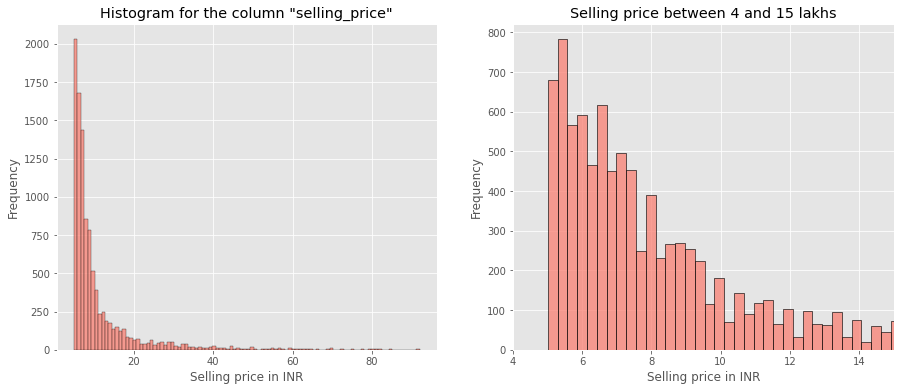

In [29]:
# Histogram for the column 'selling_price'
fig, hist = plt.subplots(1, 2, figsize=(15, 6))
# Set the title for the histogram

xlimleft = 4
xlimright = 15
bins = round( 50 * max(df['selling_price']) / xlim)


hist_norm = sns.histplot(df['selling_price'], bins=100, color='salmon', edgecolor='black', linewidth=0.3, ax=hist[0])
hist_norm.set_title('Histogram for the column "selling_price"')
hist_norm.set_xlabel('Selling price in INR')
hist_norm.set_ylabel('Frequency')

hist_norm_xlim = sns.histplot(df['selling_price'], bins=bins, color='salmon', edgecolor='black', linewidth=0.6 ,ax=hist[1])
hist_norm_xlim.set_xlim(xlimleft, xlimright)
hist_norm_xlim.set_title('Selling price between 4 and 15 lakhs')
hist_norm_xlim.set_xlabel('Selling price in INR')
hist_norm_xlim.set_ylabel('Frequency')

There is a **strong positive skewness** in the selling price. To better analyze the data we would be plotting the log transformation along with the square root transformation below.

Text(0, 0.5, 'Frequency')

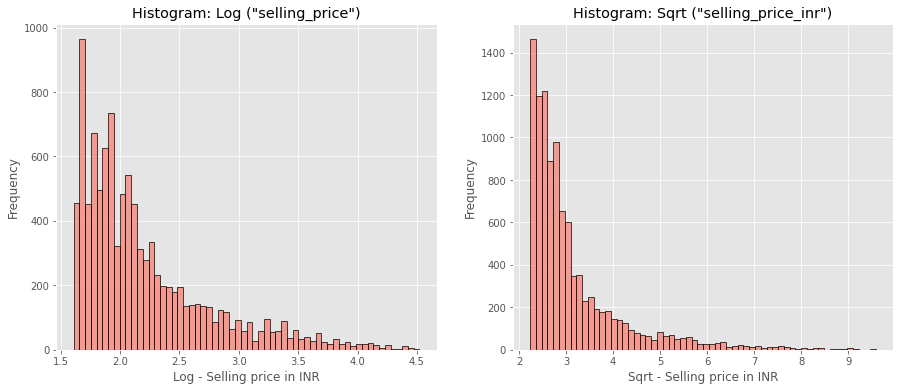

In [30]:
# Plot the histogram of the log and root transformation of the column 'selling_price'
fig, hist = plt.subplots(1, 2, figsize=(15, 6))

hist_log = sns.histplot(np.log(df['selling_price']), bins=60, color='salmon', edgecolor='black', linewidth=0.7, ax=hist[0])
hist_log.set_title('Histogram: Log ("selling_price")')
hist_log.set_xlabel('Log - Selling price in INR')
hist_log.set_ylabel('Frequency')

hist_root = sns.histplot(np.sqrt(df['selling_price']), bins=60, color='salmon', edgecolor='black', linewidth=0.7, ax=hist[1])
hist_root.set_title('Histogram: Sqrt ("selling_price_inr")')
hist_root.set_xlabel('Sqrt - Selling price in INR')
hist_root.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

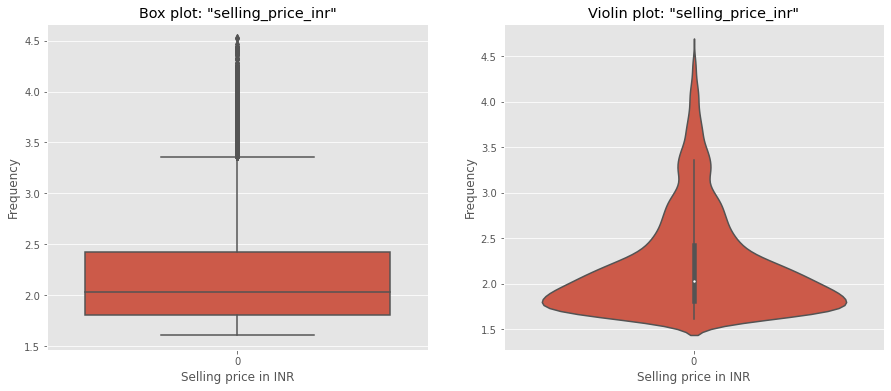

In [31]:
# Box plot and violin plot for the log transformation of column 'selling_price_inr'
fig, ran = plt.subplots(1, 2, figsize=(15, 6))

box = sns.boxplot(data=np.log(df['selling_price']), ax=ran[0])
box.set_title('Box plot: "selling_price_inr"')
box.set_xlabel('Selling price in INR')
box.set_ylabel('Frequency')

violin = sns.violinplot(data=np.log(df['selling_price']), ax=ran[1])
violin.set_title('Violin plot: "selling_price_inr"')
violin.set_xlabel('Selling price in INR')
violin.set_ylabel('Frequency')

#### Distance driven: `km_driven`

Summary: 
- The mean distance driven is around 53,280 km or 33,100 miles
- The median is around 47,900 km or 29,760 miles
- The CV is very large, 106%
- The kurtosis of 1868 suggests that outlier values are present and influence the data.
- Skewness is 30, i.e. the data is highly skewed (positive skewness).

In [32]:
data_km_driven = analyze_data(df, 'km_driven', n=5)

	Analyzing: Column "km_driven" is numeric

Overview of column "km_driven"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        2480        |
|   Distinct %   | 24.028679391531828 |
| Missing Count  |         0          |
|   Missing %    |        0.0         |
|      Mean      | 53280.97878112586  |
|    Minimum     |        581         |
|    Maximum     |      3800000       |
+----------------+--------------------+


Quantile stats for column "km_driven"
+---------------------+----------+
|      Statistic      |  Value   |
+---------------------+----------+
|       Minimum       |   581    |
|    5th Percentile   |  9000.0  |
|  First Quartile, Q1 | 26000.0  |
|        Median       | 47900.0  |
|  Third Quartile, Q3 | 70000.0  |
|   95th Percentile   | 120000.0 |
|       Maximum       | 3800000  |
|        Range        | 3799419  |
| Interquartile Range | 44000.0  |
+---------------------+---

Text(0, 0.5, 'Frequency')

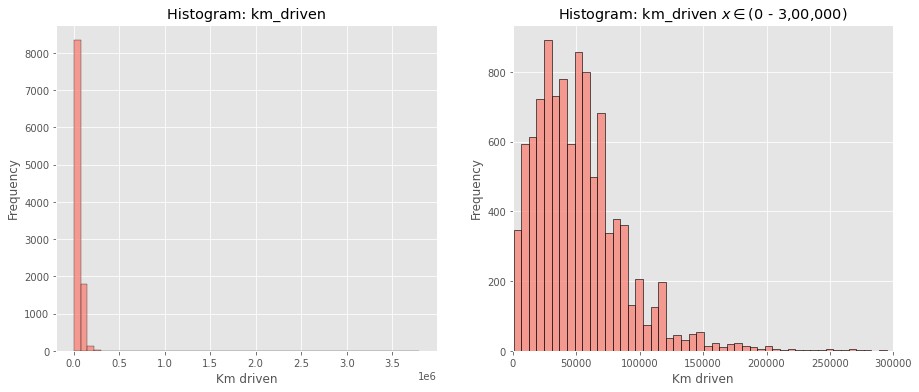

In [31]:
# Plot the histogram of the column 'km_driven'
fig, hist = plt.subplots(1, 2, figsize=(15, 6))
xlim = 3e5
bins = round( 50 * max(df['km_driven']) / xlim)

hist_norm = sns.histplot(df['km_driven'], bins=50, color='salmon', edgecolor='black', linewidth=0.3, ax=hist[0])
hist_norm.set_title('Histogram: km_driven')
hist_norm.set_xlabel('Km driven')
hist_norm.set_ylabel('Frequency')

hist_norm_xlim = sns.histplot(df['km_driven'], bins=bins, color='salmon', edgecolor='black', linewidth=0.6 ,ax=hist[1])
hist_norm_xlim.set_xlim([0, xlim])
hist_norm_xlim.set_title('Histogram: km_driven $x \in $(0 - 3,00,000)')
hist_norm_xlim.set_xlabel('Km driven')
hist_norm_xlim.set_ylabel('Frequency')

Since it is highly skewed, we would be plotting the log and sqrt transformation of the distance driven.

Text(0, 0.5, 'Frequency')

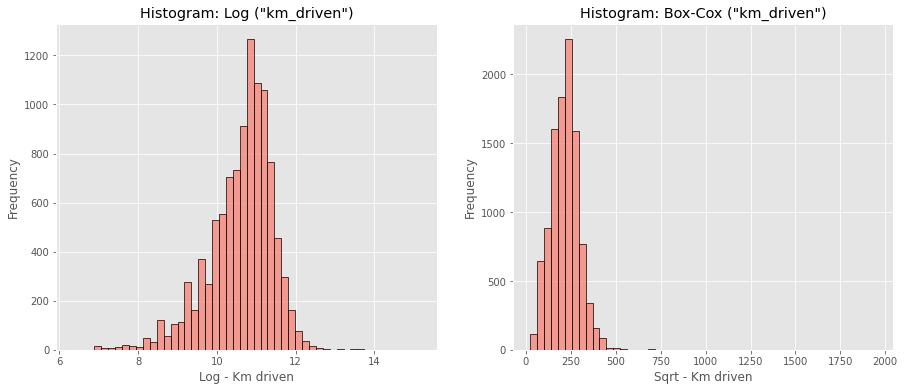

In [34]:
# Plot the histogram of the log and root transformation of the column 'km_driven'
fig, hist = plt.subplots(1, 2, figsize=(15, 6))

hist_log = sns.histplot(np.log(df['km_driven']), bins=50, color='salmon', edgecolor='black', linewidth=0.7, ax=hist[0])
hist_log.set_title('Histogram: Log ("km_driven")')
hist_log.set_xlabel('Log - Km driven')
hist_log.set_ylabel('Frequency')

hist_root = sns.histplot(np.sqrt(df['km_driven']), bins=50, color='salmon', edgecolor='black', linewidth=0.7, ax=hist[1])
hist_root.set_title('Histogram: Box-Cox ("km_driven")')
hist_root.set_xlabel('Sqrt - Km driven')
hist_root.set_ylabel('Frequency')

Text(0.5, 1.0, 'Box plot: Sqrt ("km_driven")')

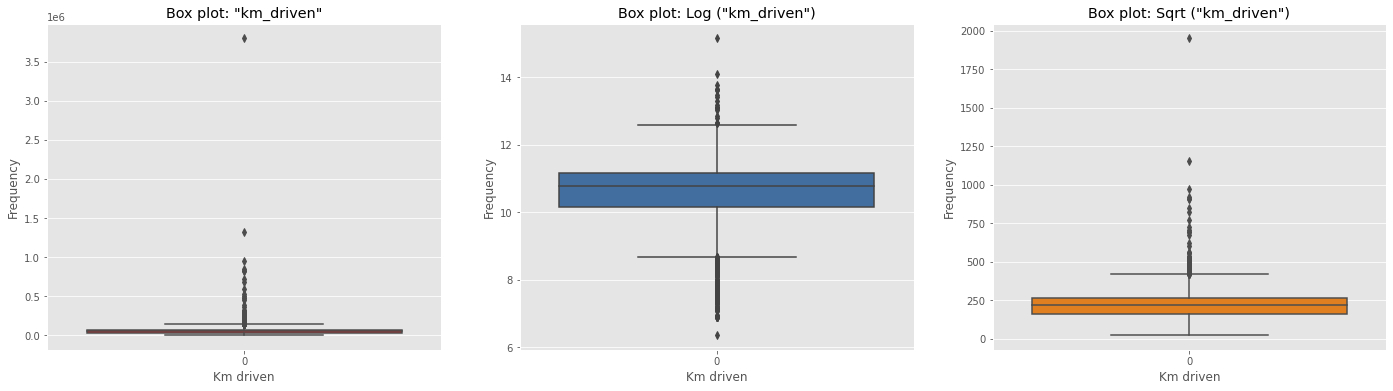

In [35]:
# Let's use a box plot to visualize the distribution of the column 'km_driven'
fig, box = plt.subplots(1, 3, figsize=(24, 6))
for box_plot in box:
	box_plot.set_xlabel('Km driven')
	box_plot.set_ylabel('Frequency')

box_original = sns.boxplot(data=df['km_driven'], ax=box[0], color='red')
box_original.set_title('Box plot: "km_driven"')

box_log = sns.boxplot(data=np.log(df['km_driven']), ax=box[1], color='#326EAD')
box_log.set_title('Box plot: Log ("km_driven")')

box_root = sns.boxplot(data=np.sqrt(df['km_driven']), ax=box[2], color='#ff7f00')
box_root.set_title('Box plot: Sqrt ("km_driven")')

As is apparent from the above plots, there are outliers present in the data which need to be treated in the **Feature Engineering** section.

#### Engine Size: `engine`

Summary: 
- There are only 127 distinct values 
- The mean engine size is 1685 cc
- The median is 1498 cc
- The CV is acceptable, 32%
- The kurtosis of 2.96
- Skewness 1.40, meaning the data is not very skewed

In [36]:
analyze_data(df, 'engine', n=5)

	Analyzing: Column "engine" is numeric

Overview of column "engine"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        127         |
|   Distinct %   | 1.2305009204534443 |
| Missing Count  |         0          |
|   Missing %    |        0.0         |
|      Mean      | 1685.5550818719116 |
|    Minimum     |        0.0         |
|    Maximum     |       5998.0       |
+----------------+--------------------+


Quantile stats for column "engine"
+---------------------+--------+
|      Statistic      | Value  |
+---------------------+--------+
|       Minimum       |  0.0   |
|    5th Percentile   | 1197.0 |
|  First Quartile, Q1 | 1248.0 |
|        Median       | 1498.0 |
|  Third Quartile, Q3 | 1995.0 |
|   95th Percentile   | 2953.0 |
|       Maximum       | 5998.0 |
|        Range        | 5998.0 |
| Interquartile Range | 747.0  |
+---------------------+--------+


Descriptive stats for co

{'quantile_stats': {'min': 0.0,
  '5%': 1197.0,
  'Q1': 1248.0,
  'median': 1498.0,
  'Q3': 1995.0,
  '95%': 2953.0,
  'max': 5998.0,
  'range': 5998.0,
  'IQR': 747.0},
 'descriptive_stats': {'mean': 1685.5550818719116,
  'sum': 17396614.0,
  'var': 298690.21462557715,
  'std': 546.5255846029326,
  'CV': 0.32424071481305883,
  'kurtosis': 2.9618460941925506,
  'MAD': 444.6598685818592,
  'skewness': 1.4027378714671863,
  'mono': False},
 'extremums': {'max_n': 5998.0    2
  5461.0    4
  4999.0    1
  4951.0    4
  4806.0    3
  Name: engine, dtype: int64, 'min_n': 0.0       2
  72.0      3
  909.0     4
  998.0    85
  999.0    46
  Name: engine, dtype: int64},
 'common_values':     value  count       freq
 0  1197.0   1366  13.235152
 1  1248.0   1280  12.401899
 2  1498.0    900   8.720085
 3  2179.0    577   5.590544
 4  1497.0    501   4.854181}

Text(0, 0.5, 'Frequency')

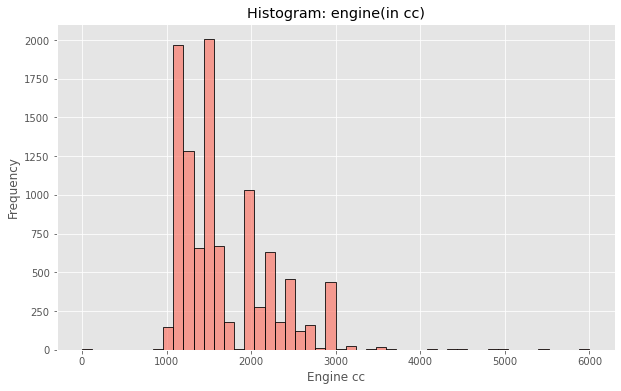

In [37]:
# Plot the histogram of the column 'engine_cc'
fig, hist = plt.subplots(1, 1, figsize=(10, 6))

hist_or = sns.histplot(df['engine'], bins=50, color='salmon', edgecolor='black', linewidth=0.8, ax=hist)
hist_or.set_title('Histogram: engine(in cc)')
hist_or.set_xlabel('Engine cc')
hist_or.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

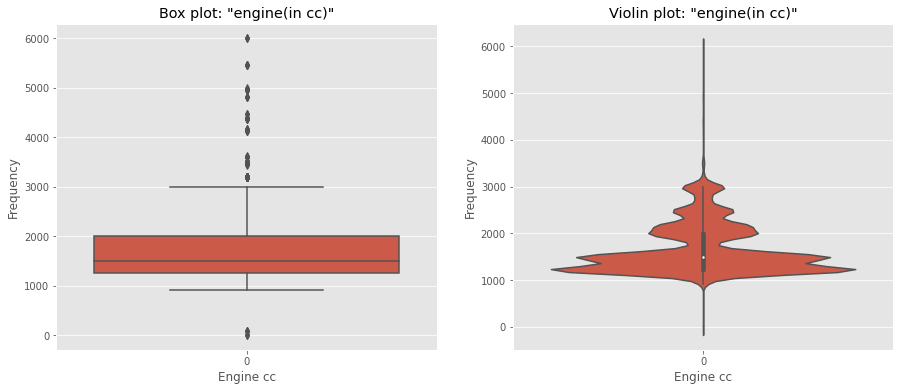

In [38]:
# Box plot and violin plot for the column 'engine_cc'
fig, ran = plt.subplots(1, 2, figsize=(15, 6))

box = sns.boxplot(data=df['engine'], ax=ran[0])
box.set_title('Box plot: "engine(in cc)"')
box.set_xlabel('Engine cc')
box.set_ylabel('Frequency')

violin = sns.violinplot(data=df['engine'], ax=ran[1])
violin.set_title('Violin plot: "engine(in cc)"')
violin.set_xlabel('Engine cc')
violin.set_ylabel('Frequency')

- Due to their being so few distinct values, we can categorize the engine size into ordinal groups later in the **Feature Engineering** section to see its impact on the model prediction.
- The presence of outliers is clearly visible in the above plots.

#### Horsepower: `max_power`

Summary: 
- There are 387 distinct values (which is large but certainly not continuous considering the dataset size)
- The mean power is 118 bhp
- The median is 102 bhp 
- The CV is high, 40%
- The kurtosis is 7.3 indicating the presence of fatter tails
- Skewness 2.06 indicates postively skewed data

In [39]:
analyze_data(df, 'max_power', n=5)

	Analyzing: Column "max_power" is numeric

Overview of column "max_power"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        387         |
|   Distinct %   | 3.7496366631140394 |
| Missing Count  |         0          |
|   Missing %    |        0.0         |
|      Mean      | 118.53692423214804 |
|    Minimum     |       41.57        |
|    Maximum     |       600.0        |
+----------------+--------------------+


Quantile stats for column "max_power"
+---------------------+--------+
|      Statistic      | Value  |
+---------------------+--------+
|       Minimum       | 41.57  |
|    5th Percentile   |  74.0  |
|  First Quartile, Q1 |  86.7  |
|        Median       | 102.0  |
|  Third Quartile, Q3 | 140.0  |
|   95th Percentile   | 201.15 |
|       Maximum       | 600.0  |
|        Range        | 558.43 |
| Interquartile Range |  53.3  |
+---------------------+--------+


Descriptive sta

{'quantile_stats': {'min': 41.57,
  '5%': 74.0,
  'Q1': 86.7,
  'median': 102.0,
  'Q3': 140.0,
  '95%': 201.15,
  'max': 600.0,
  'range': 558.43,
  'IQR': 53.3},
 'descriptive_stats': {'mean': 118.53692423214804,
  'sum': 1223419.595,
  'var': 2279.8506433657703,
  'std': 47.74778155439026,
  'CV': 0.4028093512944444,
  'kurtosis': 7.398626837037089,
  'MAD': 35.604371268841255,
  'skewness': 2.061479869882212,
  'mono': False},
 'extremums': {'max_n': 600.0    1
  575.0    1
  552.0    1
  507.0    1
  500.0    1
  Name: max_power, dtype: int64, 'min_n': 41.57    3
  45.00    4
  58.00    4
  58.16    2
  58.33    2
  Name: max_power, dtype: int64},
 'common_values':    value  count      freq
 0   88.5    654  6.336595
 1   74.0    423  4.098440
 2   81.8    402  3.894971
 3   98.6    331  3.207054
 4  140.0    315  3.052030}

Text(0, 0.5, 'Frequency')

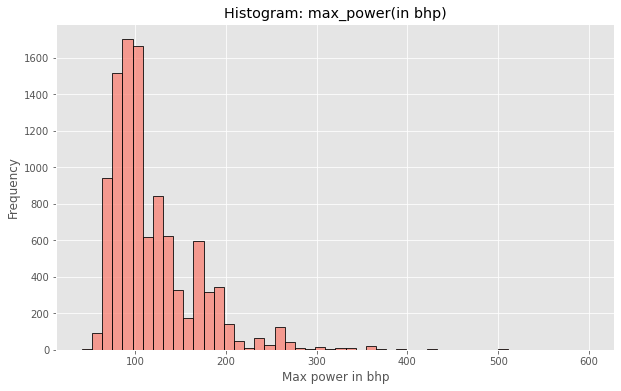

In [40]:
# Plot the histogram of the column 'max_power_bhp'
fig, hist = plt.subplots(1, 1, figsize=(10, 6))

hist_or = sns.histplot(df['max_power'], bins=50, color='salmon', edgecolor='black', linewidth=0.8, ax=hist)
hist_or.set_title('Histogram: max_power(in bhp)')
hist_or.set_xlabel('Max power in bhp')
hist_or.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

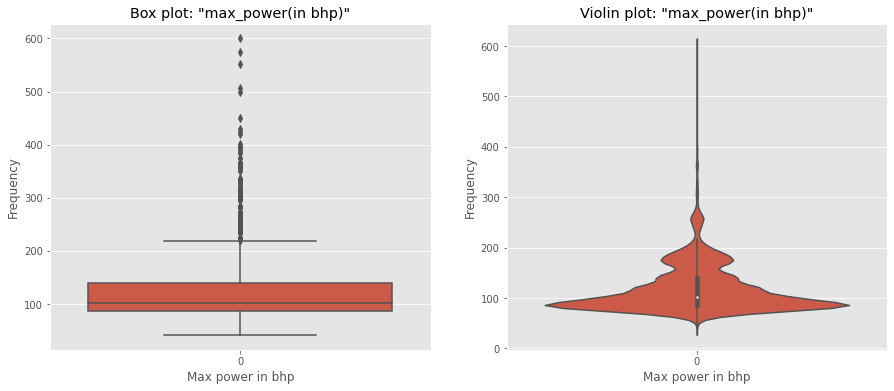

In [41]:
# Plot the box plot and violin plot for the column 'max_power_bhp'
fig, ran = plt.subplots(1, 2, figsize=(15, 6))

box = sns.boxplot(data=df['max_power'], ax=ran[0])
box.set_title('Box plot: "max_power(in bhp)"')
box.set_xlabel('Max power in bhp')
box.set_ylabel('Frequency')

violin = sns.violinplot(data=df['max_power'], ax=ran[1])
violin.set_title('Violin plot: "max_power(in bhp)"')
violin.set_xlabel('Max power in bhp')
violin.set_ylabel('Frequency')

We see some similar patterns in the above plots as we saw in the `engine_cc` plots. The presence of outliers seem to be affecting the mean and spread of the data.

### 2.2.2 Categorical Features

#### Name: `name`

Summary: 
- There are 2126 distinct values (15%) <span style="color: #FF5555;">(very high cardinality)</span>

In [42]:
data_name = analyze_data(df, 'full_name')

Column "full_name" is categorical
Overview of column "full_name"
+----------------+--------------------+
|    Measure     |       Value        |
+----------------+--------------------+
| Distinct Count |        2126        |
|   Distinct %   | 20.598779188063173 |
| Missing Count  |         0          |
|   Missing %    |        0.0         |
+----------------+--------------------+


Common values for column "full_name"
+-------------------------------+-------+---------------------+
|             Value             | Count |      Frequency      |
+-------------------------------+-------+---------------------+
|     Maruti Swift Dzire VDI    |  141  |  1.3661466912120919 |
|     Mahindra XUV500 W8 2WD    |   63  |  0.6104059684139134 |
| Maruti Vitara Brezza ZDi Plus |   57  |  0.5522720666602073 |
|    Maruti Vitara Brezza ZDi   |   51  |  0.4941381649065013 |
|    Maruti Baleno Delta 1.2    |   50  | 0.48444918128088366 |
+-------------------------------+-------+---------------------+


#### Fuel: `fuel_type`

Summary: 
- 4 distinct values
- *Diesel* and *Pertrol* make up for 99.2% of the data

In [43]:
data_fuel = analyze_data(df, 'fuel_type')

Column "fuel_type" is categorical
Overview of column "fuel_type"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          4           |
|   Distinct %   | 0.038755934502470696 |
| Missing Count  |          0           |
|   Missing %    |         0.0          |
+----------------+----------------------+


Common values for column "fuel_type"
+----------+-------+---------------------+
|  Value   | Count |      Frequency      |
+----------+-------+---------------------+
|  Diesel  |  6581 |  63.76320124018991  |
|  Petrol  |  3667 |    35.52950295514   |
|   CNG    |   64  |  0.620094952039531  |
| Electric |   9   | 0.08720085263055906 |
+----------+-------+---------------------+




Text(0, 0.5, 'Frequency')

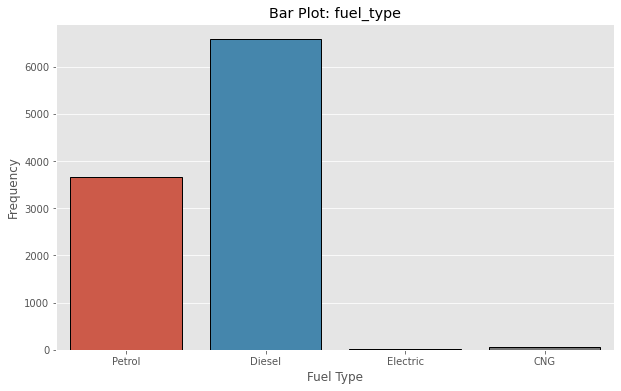

In [44]:
# Plot the bar plot for the column 'fuel_type'
fig, bar = plt.subplots(1, 1, figsize=(10, 6))

bar = sns.countplot(x=df['fuel_type'], edgecolor='#000', linewidth= 1)
bar.set_title('Bar Plot: fuel_type')
bar.set_xlabel('Fuel Type')
bar.set_ylabel('Frequency')

#### Seller Type: `seller_type`

Summary: 
- There are only 3 distinct values
- ~66% "Dealers", ~33% "Individual" and ~1% "Trustmark Dealer"

In [45]:
data_seller_type = analyze_data(df, 'seller_type')

Column "seller_type" is categorical
Overview of column "seller_type"
+----------------+---------------------+
|    Measure     |        Value        |
+----------------+---------------------+
| Distinct Count |          3          |
|   Distinct %   | 0.02906695087685302 |
| Missing Count  |          0          |
|   Missing %    |         0.0         |
+----------------+---------------------+


Common values for column "seller_type"
+------------------+-------+-------------------+
|      Value       | Count |     Frequency     |
+------------------+-------+-------------------+
|      Dealer      |  6787 | 65.75913186706714 |
|    Individual    |  3430 | 33.23321383586862 |
| Trustmark Dealer |  104  | 1.007654297064238 |
+------------------+-------+-------------------+




Text(0, 0.5, 'Frequency')

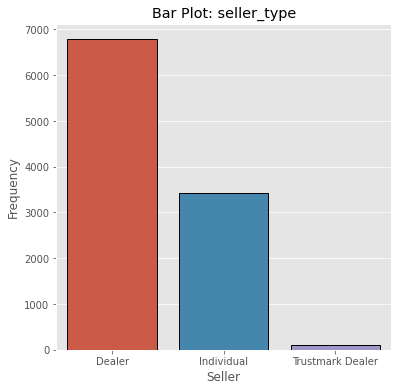

In [46]:
# Plot the bar plot for the column 'seller_type'
fig, bar = plt.subplots(1, 1, figsize=(6, 6))

bar = sns.countplot(x=df['seller_type'], edgecolor='#000', linewidth= 1)
bar.set_title('Bar Plot: seller_type')
bar.set_xlabel('Seller')
bar.set_ylabel('Frequency')

#### Transmission: `transmission_type`

Summary: 
- 2 distinct values
- *Manual* transmission cars make up for ~67.8% of the dataset rest are *Automatic*

In [47]:
data_transmission = analyze_data(df, 'transmission_type')

Column "transmission_type" is categorical
Overview of column "transmission_type"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          2           |
|   Distinct %   | 0.019377967251235348 |
| Missing Count  |          0           |
|   Missing %    |         0.0          |
+----------------+----------------------+


Common values for column "transmission_type"
+-----------+-------+--------------------+
|   Value   | Count |     Frequency      |
+-----------+-------+--------------------+
|   Manual  |  7004 | 67.86164131382618  |
| Automatic |  3317 | 32.138358686173824 |
+-----------+-------+--------------------+




Text(0, 0.5, 'Frequency')

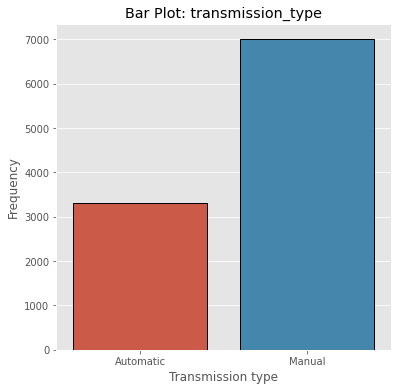

In [48]:
# Plot the bar plot for the column 'fuel'
fig, bar = plt.subplots(1, 1, figsize=(6, 6))

bar = sns.countplot(x=df['transmission_type'], edgecolor='#000', linewidth= 1)
bar.set_title('Bar Plot: transmission_type')
bar.set_xlabel('Transmission type')
bar.set_ylabel('Frequency')

#### Owner: `owner_type`

Summary: 
- 2 distinct values
- The data is dominated by *First Owner* type (~99.99%)

In [49]:
data_owner = analyze_data(df, 'owner_type')

Column "owner_type" is categorical
Overview of column "owner_type"
+----------------+----------------------+
|    Measure     |        Value         |
+----------------+----------------------+
| Distinct Count |          2           |
|   Distinct %   | 0.019377967251235348 |
| Missing Count  |          0           |
|   Missing %    |         0.0          |
+----------------+----------------------+


Common values for column "owner_type"
+--------------+-------+----------------------+
|    Value     | Count |      Frequency       |
+--------------+-------+----------------------+
| First Owner  | 10320 |  99.99031101637438   |
| Second Owner |   1   | 0.009688983625617672 |
+--------------+-------+----------------------+




Text(0, 0.5, 'Frequency')

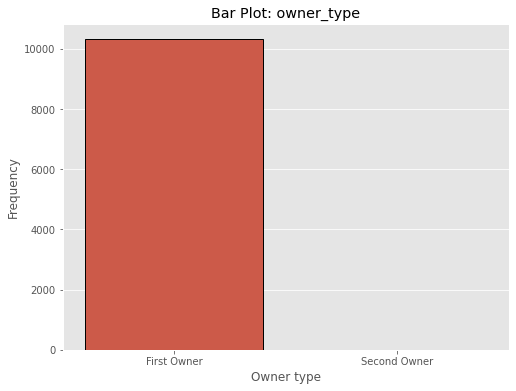

In [50]:
# Plot the bar plot for the column 'fuel'
fig, bar = plt.subplots(1, 1, figsize=(8, 6))

bar = sns.countplot(x=df['owner_type'], edgecolor='#000', linewidth= 1)
bar.set_title('Bar Plot: owner_type')
bar.set_xlabel('Owner type')
bar.set_ylabel('Frequency')

#### Seats: `seats`

Summary: 
This one's tricky. While seats has integer datatype and my helper function recognises it as numeric, I think we should treat it as a categorical variable.
- 8 distinct values
- Most cars have *5* seats (about 75%)

In [51]:
data_seats = analyze_data(df, 'seats')

	Analyzing: Column "seats" is numeric

Overview of column "seats"
+----------------+---------------------+
|    Measure     |        Value        |
+----------------+---------------------+
| Distinct Count |          8          |
|   Distinct %   | 0.07751186900494139 |
| Missing Count  |          0          |
|   Missing %    |         0.0         |
|      Mean      |  5.475825985854084  |
|    Minimum     |         2.0         |
|    Maximum     |         10.0        |
+----------------+---------------------+


Quantile stats for column "seats"
+---------------------+-------+
|      Statistic      | Value |
+---------------------+-------+
|       Minimum       |  2.0  |
|    5th Percentile   |  5.0  |
|  First Quartile, Q1 |  5.0  |
|        Median       |  5.0  |
|  Third Quartile, Q3 |  5.0  |
|   95th Percentile   |  7.0  |
|       Maximum       |  10.0 |
|        Range        |  8.0  |
| Interquartile Range |  0.0  |
+---------------------+-------+


Descriptive stats for column 

Text(0, 0.5, 'Frequency')

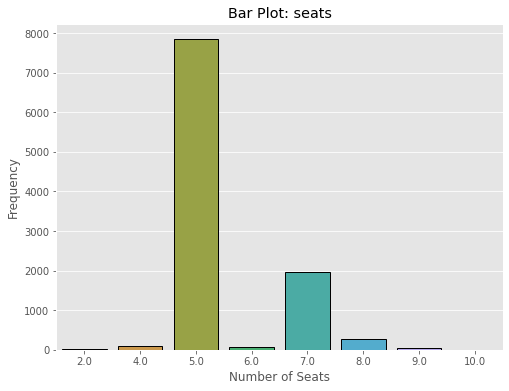

In [52]:
# Plot the bar plot for the column 'fuel'
fig, bar = plt.subplots(1, 1, figsize=(8, 6))

bar = sns.countplot(x=df['seats'], edgecolor='#000', linewidth= 1)
bar.set_title('Bar Plot: seats')
bar.set_xlabel('Number of Seats')
bar.set_ylabel('Frequency')

## 2.3 Correlation Analysis (bivariate analysis)

### 2.3.1 Qualitative Analysis

#### Categorical and Numerical

Descriptive statistics or histogram of Y​ per unique values of Y

In [32]:
# # %matplotlib inline
# # Due to high cardinality, drop the column 'name'
# col = df.columns.values
# col = np.delete(col, np.where(col == 'name'))

# feature_1 = widgets.ToggleButtons(
#     options=col,
#     description='Feature 1:',
#     disabled=False,
#     button_style='', # 'success', 'info', 'warning', 'danger' or ''
# )

# feature_2 = widgets.ToggleButtons(
#     options=col,
#     description='Feature 2:',
#     disabled=False,
#     button_style='', # 'success', 'info', 'warning', 'danger' or ''
# )


# def update_plot(feature_1, feature_2):
# 	# Check if both the features are numerical
# 	feature_1_is_numerical = df[feature_1].dtype in ['int64', 'float64']
# 	feature_2_is_numerical = df[feature_2].dtype in ['int64', 'float64']

# 	if feature_1_is_numerical and feature_2_is_numerical:
# 		# Plot the scatter plot for the two features
# 		fig, scatter = plt.subplots(1, 1, figsize=(10, 6))
# 		scatter = sns.scatterplot(x=df[feature_1], y=df[feature_2], data=df, ax=scatter)
# 		scatter.set_title('Scatter Plot: ' + feature_1 + ' vs ' + feature_2)
# 		scatter.set_xlabel(feature_1)
# 		scatter.set_ylabel(feature_2)
# 		plt.show()
	
# 	elif feature_1_is_numerical and not feature_2_is_numerical:
# 		# Plot the histogram of the feature_1 per unique value of feature_2
# 		fig, hist = plt.subplots(1, 1, figsize=(10, 6))
# 		hist = sns.histplot(x=df[feature_1], hue=df[feature_2], bins=50, data=df, ax=hist)
# 		hist.set_title('Histogram: ' + feature_1 + ' vs ' + feature_2)
# 		hist.set_xlabel(feature_1)
# 		hist.set_ylabel('Frequency')
# 		plt.show()
	
# 	elif not feature_1_is_numerical and feature_2_is_numerical:
# 		# Plot the histogram of the feature_2 per unique value of feature_1
# 		fig, hist = plt.subplots(1, 1, figsize=(10, 6))
# 		hist = sns.histplot(x=df[feature_2], hue=df[feature_1],  bins=50, data=df, ax=hist)
# 		hist.set_title('Histogram: ' + feature_1 + ' vs ' + feature_2)
# 		hist.set_xlabel(feature_2)
# 		hist.set_ylabel('Frequency')
# 		plt.show()
	
# 	else:
# 		# Get the contingency table for the two features
# 		cont_table = pd.crosstab(df[feature_1], df[feature_2])
# 		# Plot the contigency table
# 		fig, cont = plt.subplots(1, 1, figsize=(10, 6))
# 		cont = sns.heatmap(cont_table, annot=True, fmt='d', ax=cont)
# 		cont.set_title('Contingency Table: ' + feature_1 + ' vs ' + feature_2)
# 		cont.set_xlabel(feature_2)
# 		cont.set_ylabel(feature_1)
# 		plt.show()

# interact(update_plot, feature_1=feature_1, feature_2=feature_2)

In [33]:
# Contingency table with unique counts of features 'fuel' per unique value of feature 'seller_type'
cont_table = pd.crosstab(df['fuel_type'], df['seller_type'])
cont_table

seller_type,Dealer,Individual,Trustmark Dealer
fuel_type,,,
CNG,50,10,4
Diesel,4298,2272,11
Electric,6,3,0
Petrol,2433,1145,89


#### Both Numerical

Sampled scatter plot: works best with a mixture of ordinal categorical and interval data

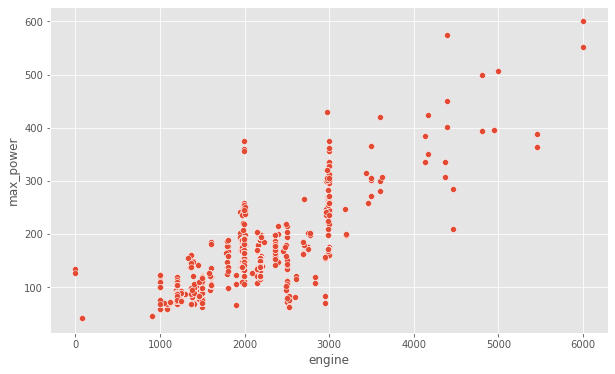

In [34]:
%matplotlib inline
feature_1 = df['engine']
feature_2 = df['max_power']
fig, scatter = plt.subplots(1, 1, figsize=(10, 6))
scatter = sns.scatterplot(x = feature_1, y=feature_2, data=df, ax=scatter)

#### Both Categorical

Contingency tables with unique counts of​ X ​per unique value of Y​ 

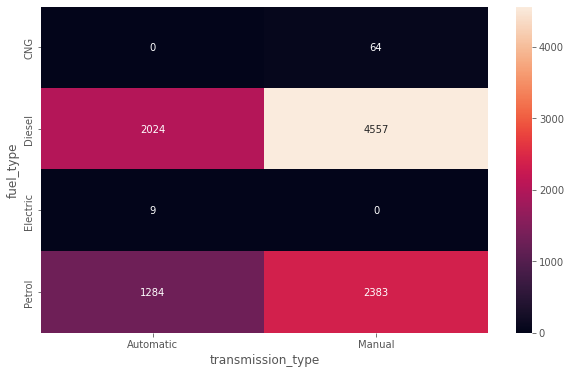

In [36]:
feature_1 = df['fuel_type']
feature_2 = df['transmission_type']
cont_table = pd.crosstab(feature_1, feature_2)

fig, cont = plt.subplots(1, 1, figsize=(10, 6))
cont = sns.heatmap(cont_table, annot=True, fmt='d')

# 3. Data Cleaning
Before performing any analysis, we need to clean the data. Here a number of preprocessing steps are performed to clean the data.

*Refer to the notebook "[Car_price_Data_cleaning.ipynb](https://github.com/Ayush863/Car_Prices-A_Prediction_Service/blob/main/Car_price_Data_cleaning.ipynb)" for this step*